In [25]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    %matplotlib widget
    figsize=(9, 3)
else:
    figsize=(14, 4)


from util import util
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ordinary Differential Equations

## Thermal Models

**Let's assume we want to model the thermal behavior of an object**

<center><img src="assets/thermal-model.png" width=45%/></center>

**Temperature obeys well-defined physical laws**

* These are described by _differential equations_
* ...And can be used to build powerful computer simulators
* If we assigning values to the model parameters, we can then study its behavior

## Thermal Models

**Let's assume we want to model the thermal behavior of an object**

<center><img src="assets/thermal-model.png" width=45%/></center>

**But what if we _don't know the parameters_**?

* Then we have an _estimation problem_
* We can solve it using Machine Learning
* Provided our model is consistent with _the physical laws_ of the simulator

## Ordinary Differential Equations

**An _Ordinary Differential Equation_ is any equation in the form:**

$$
\dot{y} = f(y, t)
$$

* Where $y$ is the _state variable_
* ...And $f$ is a function, providing the gradient of the state variable

**The peculiarities:**

* $y$ is actually a _function_ or the $t$ variable
* The $t$ variable typically (but not always) represents _time_
* ...Hence $y(t)$ is _the state at time $t$_
* The _gradient $f$_ depends on both the current state and current time

**Ordinary =** does not feature partial derivatives

## Initial Value Problem

**An _Initial Value Problem_ consists of an ODE and a initial condition**

$$\begin{align}
& \dot{y} = f(y, t) \\
& y(0) = y_0
\end{align}$$

* This can be interpreted as _running a simulation_
* Given that the initial state $y(0)$ is $y_0$, how will the state unfold?

**Initial values problems can be solved (_integrated_):**

...Exactly, using _symbolic approaches_, e.g.

$$
\dot{y} = a, y(0) = b \quad \Rightarrow \quad y(t) = ay + b
$$

* This is the method considered in typical calculus courses

...Or approximately, via _numerical approaches_

## An Example

**As an example, let's consider a simple RC circuit**

<center class="small">
<img src="assets/RC.png" width=400px/>
</center>

It's dynamic behavior is described by the ODE:

$$
\dot{V} = \frac{1}{\tau} (V_s - V)
$$

* Where $\tau = RC$

## Euler Method

**The simplest numerical approach for ODEs is called _Euler Method_**

This is obtained by:

* Considering a fixed sequence of evaluation points $\{t_k\}_{k=0}^n$
* Using a _linear approximation_ for $y(t)$ within each interval $[t_k, t_{k+1}]$
* Approximating the slope with the gradient $f$ at time $t_k$

**The pseudo code of the method consists of _a single loop_**

$$\begin{align}
& \text{for $k = 1..n$:} \\
& \quad y_k = y_{k-1} + (t_k - t_{k-1}) f(y_{k-1}, t_{k-1})
\end{align}$$
  
* The output is a sequence $\{y_k\}_{i=0}^n$, where $y_k$ is the state at time $t_k$
* $y_0$ is also an input for the algorithm

## Euler Method for the RC Circuit

**A typical Initial Value Problem solver API requires to define**

The function that characterizes the equation, i.e. $f(y, t)$:

In [2]:
tau, Vs = 8, 12
f = lambda y, t: 1./tau * (Vs - y)

The initial state $y_0$ and the evaluation points $\{t_i\}_{i=0}^n$

In [3]:
y0 = (0,) # We start from an empty capacitor
t = np.linspace(0, 40, 12)

Then we can call the solver itself (the code is in the `util` module)

In [5]:
y, dy = util.euler_method(f, y0, t, return_gradients=True)

## Euler Method for the RC Circuit

**Visually, the method works as follows:**

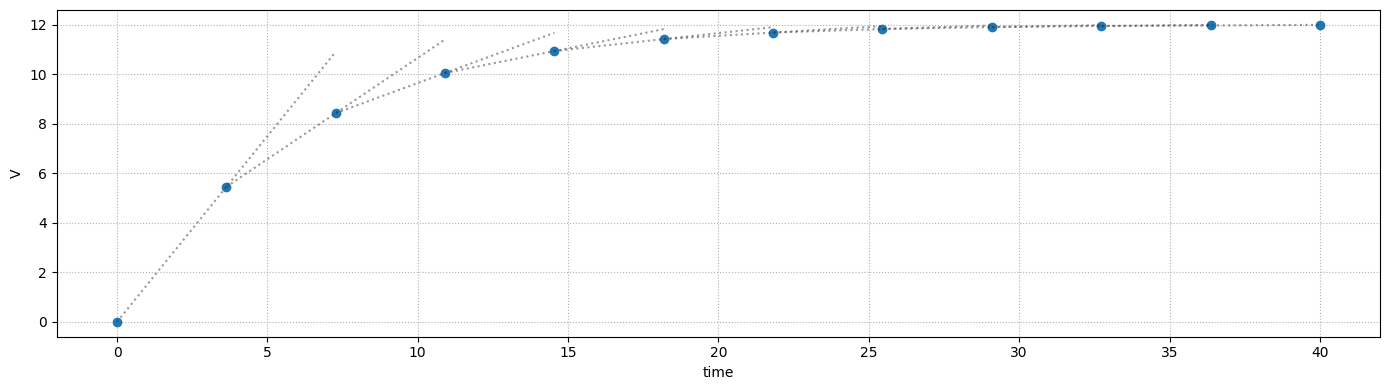

In [8]:
util.plot_euler_method(y, t, dy=dy, xlabel='time', ylabel='V', figsize=figsize)

* The dots represent _evaluated states_
* The _slope_ of the lines corresponds to the _gradient at each step_ 

## ODE Integration Methods

**The Euler method is the simplest ODE integration approach**

...But also one of the worst in terms of accuracy

* This is due to errors in the local approximation
* ...And forces to use very small steps to obtain high-quality results

**There are many alternative integration methods**, e.g.:

* [Backward Euler method](https://en.wikipedia.org/wiki/Backward_Euler_method)
  - Like Euler method, but we use the gradient at the _next_ state
  - In practice it requires to solve a (typically non-linear) equation
* [Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)
  - It's a family of method (Euler method is the simplest version)
  - They combine multiple gradients to obtain a local slope

# "Learning" ODEs

## "Learning" ODEs

**The parameters of an ODE can be _estimated_ from data**

Formally, this "training" problem amounts to solving:

$$
\text{argmin}_\theta \left\{ L(y(\hat{t}), \hat{y}) \mid
\dot{y} = f(y, t, \theta), y(0) = \hat{y}_0 \right\}
$$

Where:

* $\{\hat{t}_k \}_{k=0}^n$ is a sequence of points for which measurements are available
* $\{\hat{y}_k \}_{k=0}^n$ are the corresponding state measurements
* $f$ is a _parameterized_ gradient function
* $L$ is a loss function (e.g. the classical MSE)

**Intuitively, we require the integrated ODE to be close to the real one**

* The goal is to choose the parameters (e.g. $\tau, V_s$) so as to achieve this

<div class=big>How can we deal with that?</div>

## "Learning" ODEs

**We start from observing that every step in the Euler method is _differentiable_**

...If we assume $f$ to be differentiable (which is often the case):

$$y_k = y_{k-1} + (t_k - t_{k-1}) f(y_{k-1}, t_{k-1})$$


* This is actually true for the whole Runge-Kutta family
* ...And for more advanced methods as well

**Therefore, a viable approach is to _discretize, then optimize_**

* We choose one automatic differentiation engine
* ...And we use it to solve the initial value problem using a numerical method
* Then, we compute the loss $L$
* ...And we update the parameters using (e.g.) gradient descent

## Building Ground Truth for an Example

**We'll see an example using our simple RC circuit**

Let's start by building a high-quality ground truth sequence

* We will use the `odeint` solver from scikit learn for this
* The code can be found in the `simulate_RC` function

In [12]:
V0, tau, Vs, tmax = 0, tau, Vs, 60
data = util.simulate_RC(V0, tau, Vs, tmax, steps_per_unit=1)
data.head()

,V
time,
0.0,0.000000
1.0,1.410037
2.0,2.654391
3.0,3.752529
4.0,4.721632


* `steps_per_unit` defines how many evaluations to perform per unit of time

## Building Ground Truth for an Example

**Let' check (visually) that the result is smooth enough**

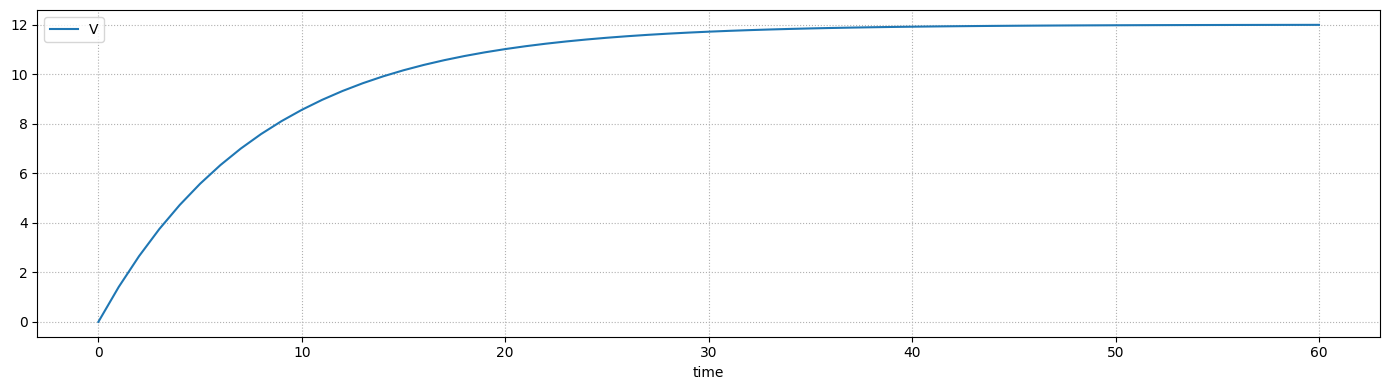

In [15]:
util.plot_df_cols(data, figsize=figsize)

* We need to ensure the data quality is high enough
* ...Since we'll treat it as our ground truth

## Outline of the Approach

**We will build a relatively simple, but quite general approach**

* We will view the (parameterized) gradient function $f(y, t, \theta)$ as a _layer type_
* ...And we will use a `keras.Model` to encode Euler method, i.e.
$$
y(\hat{t}_{k}) = y(\hat{t}_{k-1}) + (\hat{t}_{k} - \hat{t}_{k-1}) f(y(\hat{t}_{k-1}), \hat{t}_{k-1}, \theta)
$$
* Each step of the method can be viewed as _layer instance_
* ...And all instances share the same weights

**In terms of input/output:**

* The initial state corresponds to the _input_
* ...And a _secondary input_ is given by the sequence $\{\hat{t}_{k}\}_{k=0}^n$
* The _output_ is the state for each evaluation step

## Outline of the Approach

**Overall, our "architecture" looks like this:**

<center>
<img src="assets/ode.png" width=500px />
</center>

* The _input_ includes the _initial state $y_0$_ and the _evaluation points $\{\hat{t}_k\}_{k=0}^n$_
* The _output consists_ of the _sequence of state evaluations $\{y_{k}\}_{k=0}^n$_

**Overall, the signature is analogous to that of an ODE solver**

## Outline of the Approach

**Overall, our "architecture" looks like this:**

<center>
<img src="assets/ode.png" width=500px />
</center>

* Each _example_ corresponds to _an initial value problem solution_ for the same system
* ...And the architecture is very similar to a _recurrent NN_
* In particular, the "depth" grows with the number of evaluation points

## Details Matter

**In our RC circuit case, we have:**

$$\begin{align}
\operatorname{argmin}_{\tau, V_s} \ & L(y(\hat{t}), \hat{y}) \\
\text{subject to } & \dot{y} = \frac{1}{\tau} (V_s - y) \\
& y(0) = y_0
\end{align}$$

* Where the parameters to be learned are $\tau$ and $V_s$

**There are a few details we need to account for**

* For both parameters, _negative values_ make no sense
* Moreover, since we plan to use gradient descent for training
* ...We need to make sure that our initial guesses are _reasonable_

## Details Matter

**We can meet both conditions by adopting the reformulation:**

$$\begin{align}
& \tau = \sigma_\tau e^{\theta_{\tau}} \\
& V_s = \sigma_{V_s} e^{\theta_{V_s}} \\
\end{align}$$

Where the parameters to be learned are now $\theta_{\tau}$ and $\theta_{V_s}$

* Using an exponential ensures we get non-negative values
* The scaling factors $\sigma_{\tau}$ and $\sigma_{V_s}$ are user-provided
* They should lead to reasonable guesses for typical NN weight initiliazers

There are just a few mild downsides:

* The exponential may lead to numerical issues in edge cases
* We need to have a rough idea of the scale of $\tau$ and $V_s$

## RC Circuit Layer

**The layer for the RC circuit gradient is in the `RCNablaLayer` class**

```python
class RCNablaLayer(keras.layers.Layer):
    def __init__(self, tau_ref=0.1, vs_ref=0.1):
        self.tau_ref = tau_ref # store scales
        self.vs_ref = vs_ref
        p_init = tf.random_normal_initializer() # weight initializer
        self.logtau = tf.Variable( # init the \omega_\tau param
            initial_value=p_init(shape=(1, ), dtype="float32"),
            trainable=True)
        self.logvs = tf.Variable( # init the \omega_{V_s} param
            initial_value=p_init(shape=(1, ), dtype="float32"),
            trainable=True)
    
    ...
```

* In the `__init__` method we take care of weight initialization

## RC Circuit Layer

**The layer for the RC circuit gradient is in the `RCNablaLayer` class**

```python
class RCNablaLayer(keras.layers.Layer):
    ...
    
    def get_tau(self):
        return tf.math.exp(self.logtau) * self.tau_ref

    def get_vs(self):
        return tf.math.exp(self.logvs) * self.vs_ref

    def call(self, inputs):
        y, t = inputs # unpack the inputs
        return 1. / self.get_tau() * (self.get_vs() - y)
```

* We use dedicated method to obtain $\tau$ and $V_s$
* In the `call` method we compute the (ODE) gradient

## Euler Method Model

**The model for the Euler method is in the `ODEEulerModel` class**

```python
class ODEEulerModel(keras.Model):
    def __init__(self, f, **params): ...
        
    def call(self, inputs, training=False):
        y, T = inputs # unpack
        res = [y] # initial state
        for i in range(T.shape[1]-1):
            t, nt = T[:, i:i+1], T[:, i+1:i+2] # t_k and t_{k+1}
            dy = self.f([y, t], training=training) # gradient
            y = y + (nt - t) * dy # next state
            res.append(y) # store result
        res = tf.stack(res, axis=1) # concatenate
        return res
```

* The `__call__` method implements the method using tensor operators

## Euler Method Model

**The model for the Euler method is in the `ODEEulerModel` class**

```python
class ODEEulerModel(keras.Model):
    ...
        
    def train_step(self, data):
        (y0, T), yt = data # unpack
        with tf.GradientTape() as tape:
            y = self.call([y0, T], training=True) # ODE integration
            # Loss computation
            mask = ~tf.math.is_nan(yt)
            loss = self.compiled_loss(yt[mask], y[mask])
        ...
```

* The loss is computed as usual on all available measurements
* We can exclude points by setting the corresponding target to NaN

## Training Set

**We have a single sequence of measurements**

...Therefore, just a training set (no validation, no test)

* Our first input is the initial state:

In [16]:
tr_y0 = np.array(data.iloc[0]).reshape(1, -1); display(tr_y0)

array([[0.]])

* The second is the sequence of evaluation points (time steps)

In [18]:
tr_T = np.array(data.index).reshape(1, -1); display(tr_T[:, :30])

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29.]])

## Training Set

**We have a single sequence of measurements**

...Therefore, just a training set (no validation, no test)

* Then we need to prepare our ground truth

In [19]:
tr_y = np.array(data['V']).reshape(1, -1)
tr_y[:, 0] = np.nan
display(tr_y[:, :30])

array([[        nan,  1.41003718,  2.6543906 ,  3.75252866,  4.7216321 ,
         5.57686288,  6.33160139,  6.99765581,  7.58544676,  8.10417046,
         8.56194251,  8.96592493,  9.32243816,  9.63705999,  9.91471279,
        10.15974045, 10.37597661, 10.56680439, 10.73520931, 10.88382613,
        11.01498002, 11.13072291, 11.23286566, 11.32300631, 11.40255515,
        11.47275676, 11.53470947, 11.58938254, 11.63763136, 11.6802108 ]])

* This is the sequence of all measurements, with the first state "masked"

## Training Process

**We can now build and train the model**

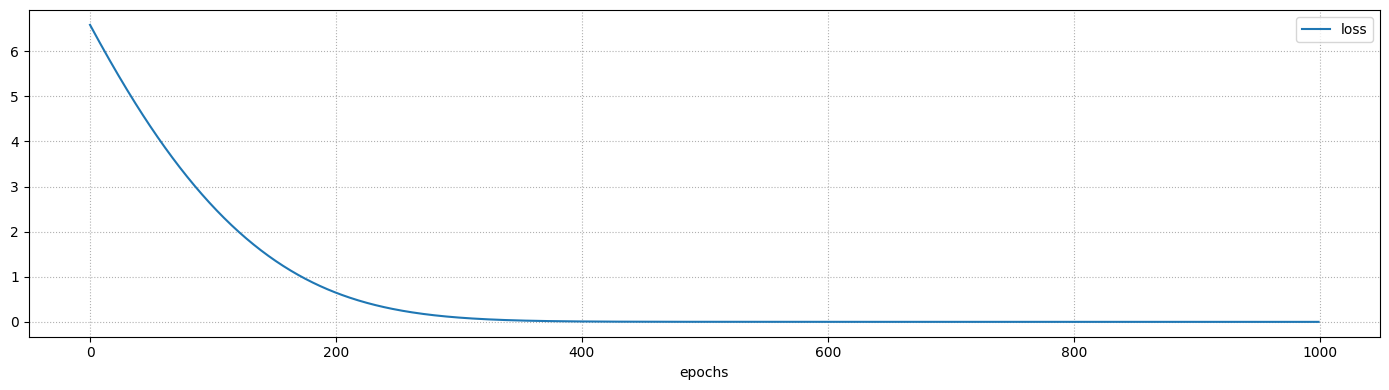

Final loss: 0.0001 (training)
CPU times: user 9.1 s, sys: 497 ms, total: 9.6 s
Wall time: 8.23 s


In [23]:
%%time
dRC = util.RCNablaLayer(tau_ref=10, vs_ref=10)
euler = util.ODEEulerModel(dRC)
history = util.train_nn_model(euler, [tr_y0, tr_T], tr_y, loss='mse', validation_split=0.0, epochs=1000)
util.plot_training_history(history, figsize=figsize)

## Some Considerations

**It seems to be working! But there are a few issues**

First, the convergence is slow

* Stopping before ~500 epochs leads to less stable results

Second, we cannot use a validation set:

* This is due to the fact that we have a single sequence

Third, we are still _not getting_ the correct parameters:

In [24]:
print(f'tau: {tau:.2f} (real), {dRC.get_tau().numpy()[0]:.2f} (estimated)')
print(f'Vs: {Vs:.2f} (real), {dRC.get_vs().numpy()[0]:.2f} (estimated)')

tau: 8.00 (real), 8.56 (estimated)
Vs: 12.00 (real), 12.01 (estimated)


**In the next section, we will see how to address these issues**